In [6]:
# embed_documents.py
from sentence_transformers import SentenceTransformer
from langchain.text_splitter import RecursiveCharacterTextSplitter
import os
import pickle
import numpy as np

# Load model
model = SentenceTransformer("all-MiniLM-L6-v2")
splitter = RecursiveCharacterTextSplitter(chunk_size=1000, chunk_overlap=50)

# data cleaning before spliting
# def clean_text(text):
#     return " ".join(text.strip().split())


# Load and split documents
all_texts = []
for filename in os.listdir("documents"):
    with open(os.path.join("documents", filename), "r", encoding="utf-8", errors="ignore") as f:
        text = f.read()
        chunks = splitter.split_text(text)
        all_texts.extend(chunks)

# Generate embeddings
embeddings = model.encode(all_texts, normalize_embeddings=True)
# Generate embeddings with batching

# embeddings = model.encode(all_texts, normalize_embeddings=True, batch_size=32, show_progress_bar=True)
# embeddings = np.array(embeddings, dtype=np.float32)


# Save as pickle for use in FAISS
with open("faiss_data.pkl", "wb") as f:
    pickle.dump({
        "texts": all_texts,
        "embeddings": np.array(embeddings)
    }, f)

print("✅ FAISS-compatible data saved.")


/home/eyasu/miniconda3/envs/main/lib/python3.10/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


✅ FAISS-compatible data saved.


Number of clusters (nlist): 3
Number of vectors in index: 5734


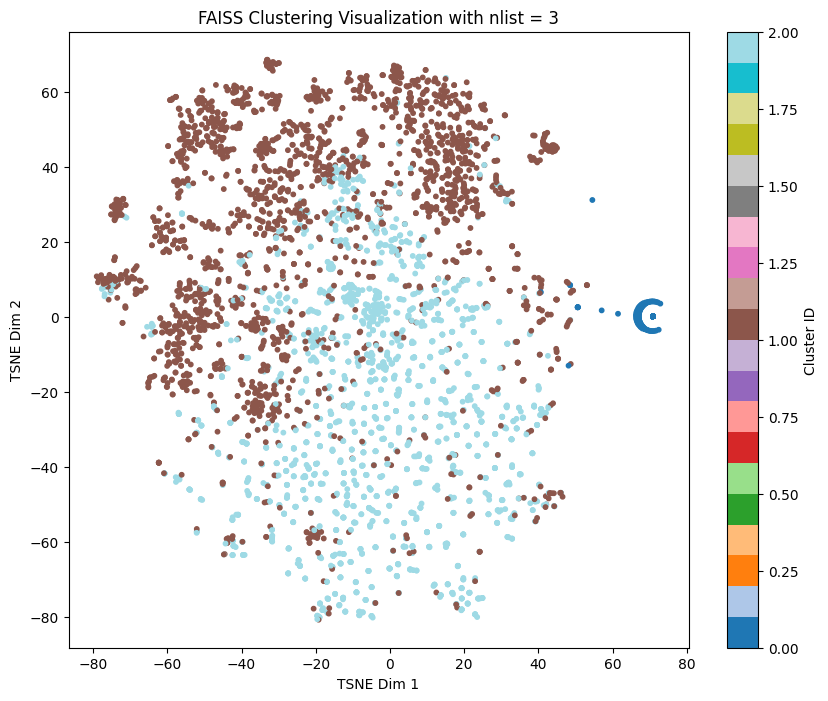

In [1]:
import faiss
import pickle
import numpy as np
from sklearn.manifold import TSNE
import matplotlib.pyplot as plt

# Load embeddings
with open("faiss_data.pkl", "rb") as f:
    data = pickle.load(f)
embeddings = data["embeddings"]

# Step 1: Reduce dimensionality for visualization
tsne = TSNE(n_components=2, perplexity=30, random_state=42)
reduced = tsne.fit_transform(embeddings)

# Step 2: Cluster with FAISS
dimension = embeddings.shape[1]
nlist = 3
quantizer = faiss.IndexFlatL2(dimension)
index = faiss.IndexIVFFlat(quantizer, dimension, nlist)
index.train(embeddings)
index.add(embeddings)

# Assign each vector to its closest centroid
_, cluster_ids = index.quantizer.search(embeddings, 1)
cluster_ids = cluster_ids.flatten()

# Step 3: Plot
print("Number of clusters (nlist):", index.nlist)
print("Number of vectors in index:", index.ntotal)

plt.figure(figsize=(10, 8))
scatter = plt.scatter(reduced[:, 0], reduced[:, 1], c=cluster_ids, cmap='tab20', s=10)
plt.title(f"FAISS Clustering Visualization with nlist = {nlist}")
plt.xlabel("TSNE Dim 1")
plt.ylabel("TSNE Dim 2")
plt.colorbar(scatter, label='Cluster ID')
plt.show()


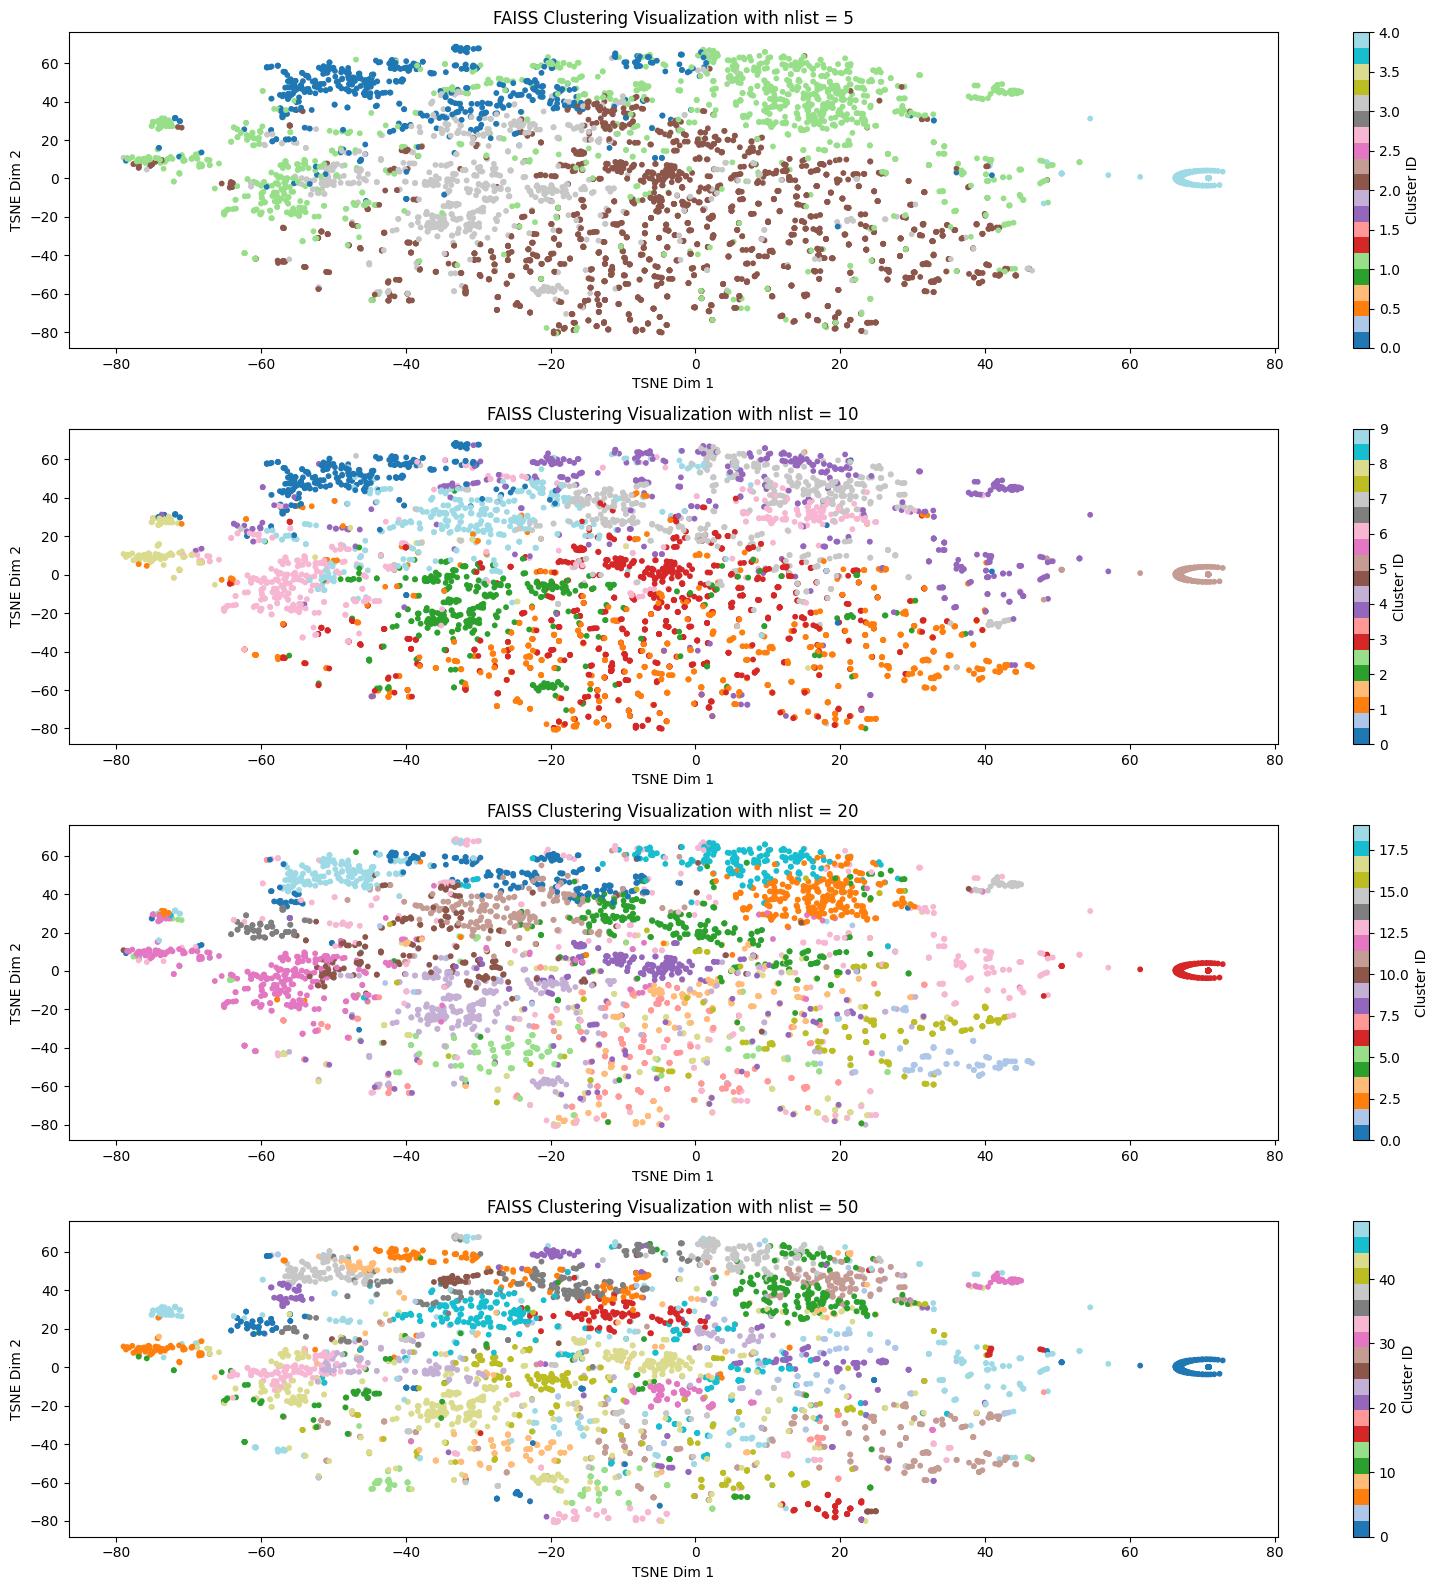

In [2]:
import faiss
import pickle
import numpy as np
from sklearn.manifold import TSNE
import matplotlib.pyplot as plt

# Load embeddings
with open("faiss_data.pkl", "rb") as f:
    data = pickle.load(f)
embeddings = data["embeddings"]

# Step 1: Reduce dimensionality for visualization (once)
tsne = TSNE(n_components=2, perplexity=30, random_state=42)
reduced = tsne.fit_transform(embeddings)

# Step 2: Plot clusters for different nlist values
nlist_values = [5, 10, 20, 50]
num_plots = len(nlist_values)

plt.figure(figsize=(16, 4 * num_plots))

for i, nlist in enumerate(nlist_values):
    dimension = embeddings.shape[1]
    quantizer = faiss.IndexFlatL2(dimension)
    index = faiss.IndexIVFFlat(quantizer, dimension, nlist)
    index.train(embeddings)
    index.add(embeddings)

    # Assign each vector to its closest centroid
    _, cluster_ids = index.quantizer.search(embeddings, 1)
    cluster_ids = cluster_ids.flatten()

    # Plot
    plt.subplot(num_plots, 1, i + 1)
    scatter = plt.scatter(reduced[:, 0], reduced[:, 1], c=cluster_ids, cmap='tab20', s=10)
    plt.title(f"FAISS Clustering Visualization with nlist = {nlist}")
    plt.xlabel("TSNE Dim 1")
    plt.ylabel("TSNE Dim 2")
    plt.colorbar(scatter, label='Cluster ID')

plt.tight_layout()
plt.show()




=== Configuration: nlist=1, nprobe=1, top_k=5 ===


=== Configuration: nlist=1, nprobe=5, top_k=5 ===


=== Configuration: nlist=1, nprobe=10, top_k=5 ===


=== Configuration: nlist=1, nprobe=15, top_k=5 ===


=== Configuration: nlist=1, nprobe=20, top_k=5 ===


=== Configuration: nlist=1, nprobe=25, top_k=5 ===


=== Configuration: nlist=5, nprobe=1, top_k=5 ===


=== Configuration: nlist=5, nprobe=5, top_k=5 ===


=== Configuration: nlist=5, nprobe=10, top_k=5 ===


=== Configuration: nlist=5, nprobe=15, top_k=5 ===


=== Configuration: nlist=5, nprobe=20, top_k=5 ===


=== Configuration: nlist=5, nprobe=25, top_k=5 ===


=== Configuration: nlist=10, nprobe=1, top_k=5 ===


=== Configuration: nlist=10, nprobe=5, top_k=5 ===


=== Configuration: nlist=10, nprobe=10, top_k=5 ===


=== Configuration: nlist=10, nprobe=15, top_k=5 ===


=== Configuration: nlist=10, nprobe=20, top_k=5 ===


=== Configuration: nlist=10, nprobe=25, top_k=5 ===


=== Configuration: nlist=15, nprobe=1, top_k

/tmp/ipykernel_1419/1117623398.py:120: FutureWarning: 

The `ci` parameter is deprecated. Use `errorbar=None` for the same effect.

  sns.lineplot(


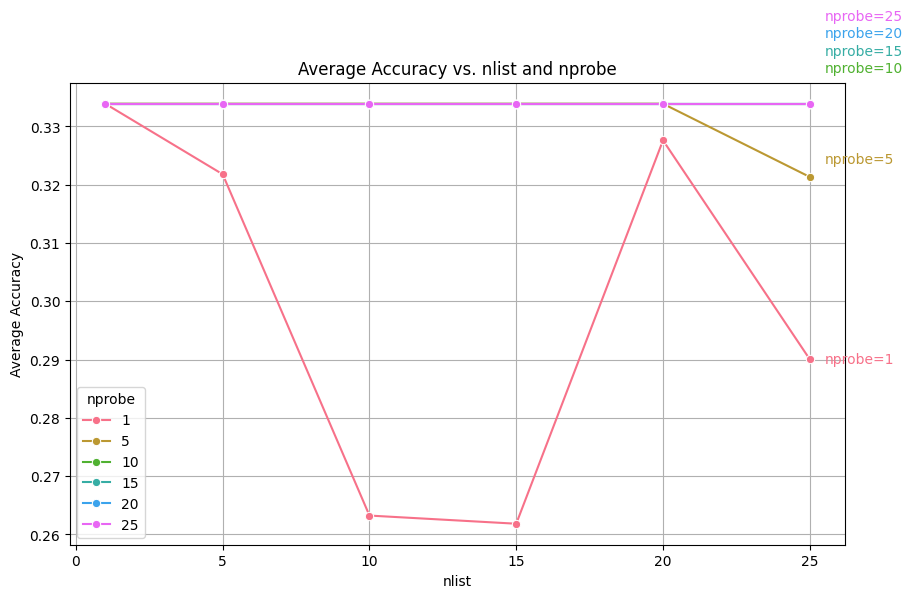

/tmp/ipykernel_1419/1117623398.py:149: FutureWarning: 

The `ci` parameter is deprecated. Use `errorbar=None` for the same effect.

  sns.lineplot(data=df, x='nlist', y='avg_speed', hue='nprobe', marker='o', ci=None)


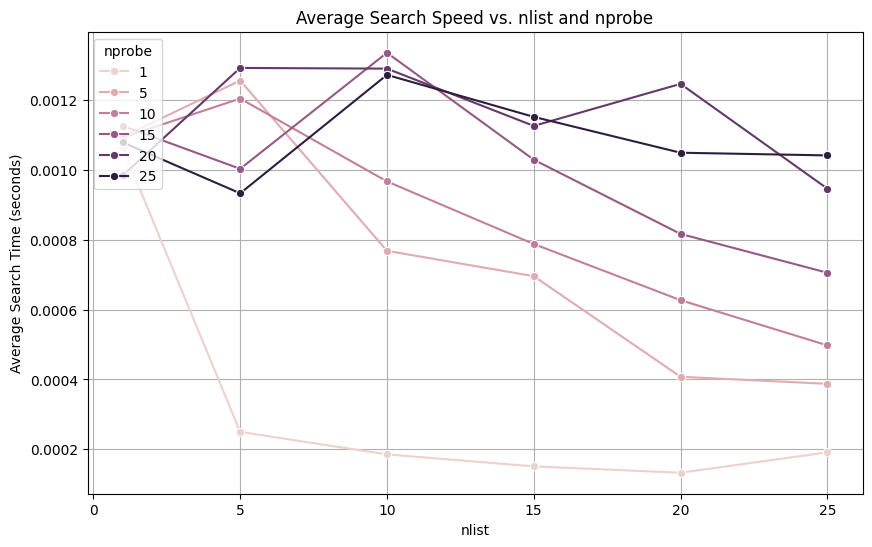

In [17]:
import json
import faiss
import numpy as np
from sentence_transformers import SentenceTransformer
import pickle
import time
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.metrics.pairwise import cosine_similarity

# Load model
model = SentenceTransformer("all-MiniLM-L6-v2")

# Load data
with open("faiss_data.pkl", "rb") as f:
    data = pickle.load(f)

texts = data["texts"]
embeddings = data["embeddings"]
dimension = embeddings.shape[1]

# Parameter values to test
nlist_values = [1, 5, 10, 15, 20, 25]
nprobe_values = [1, 5, 10, 15, 20, 25]
top_k = 5

# 10 test questions for ULHPC
questions = [
    "What is ULHPC?",
    "Who can use the ULHPC systems?",
    "How do I access the ULHPC clusters?",
    "What modules are available on ULHPC?",
    "How do I submit a job on ULHPC?",
    "What is the recommended way to load software on ULHPC?",
    "Where can I find documentation for ULHPC tools and systems?"
]

answers = [
    "ULHPC is a high-performance computing facility that provides advanced computing resources and services. HPC is crucial in academic environments to achieve high-quality results in all application areas.",
    "ULHPC is available to all faculty, staff, and students at the University of Luxembourg.",
    "You can access ULHPC clusters through SSH.",
    "ULHPC provides a variety of modules for software and libraries, including Python, R, and MATLAB. You can find here the list of the supported software modules that you can use on the ULHPC facility. (Similarity: 0.1229) 2. | [ULHPC-dl](https://hpc.uni.lu/) 3. | [ULHPC-dl](https://hpc.uni.lu/)  4. | [ULHPC-dl](https://hpc.uni.lu/) 2020b 5. | [ULHPC-toolchains](https://hpc.uni.lu/)",
    "To submit a job on ULHPC, you can use the SLURM job scheduler. From the login node you can interact with Slurm to **submit** job scripts or start interactive jobs, which will be further run on the compute nodes.",
    "The recommended way to load software on ULHPC is to use the module command. To load a software of this category, use: ` module load tools/<software>[/<version>]`",
    "Documentation for ULHPC tools and systems can be found on the ULHPC website. We have always maintained an extensive [documentation](https://hpc-docs.uni.lu) and [HPC tutorials](https://ulhpc-tutorials.readthedocs.io) available online, which aims at being the most up-to-date and comprehensive while covering many (many) topics."
]

# Function to compute similarity score between retrieved and expected answer
def compute_similarity(a, b):
    """Compute cosine similarity between two texts"""
    vect = TfidfVectorizer().fit([a, b])
    tfidf = vect.transform([a, b])
    return cosine_similarity(tfidf[0], tfidf[1])[0][0]

# Store the results
results = []

# Run experiments
for nlist in nlist_values:
    for nprobe in nprobe_values:
        print(f"\n\n=== Configuration: nlist={nlist}, nprobe={nprobe}, top_k={top_k} ===")

        # Build FAISS index
        quantizer = faiss.IndexFlatIP(dimension)
        index = faiss.IndexIVFFlat(quantizer, dimension, nlist, faiss.METRIC_INNER_PRODUCT)
        index.train(embeddings)
        index.add(embeddings)
        index.nprobe = nprobe

        total_score = 0
        total_time = 0
        for idx, question in enumerate(questions):
            query_vector = model.encode([question], normalize_embeddings=True)

            # Timing the search operation
            start_time = time.time()
            D, I = index.search(query_vector, top_k)
            duration = time.time() - start_time
            total_time += duration

            # Get top-k result texts
            retrieved = [texts[i] for i in I[0]]  # Top-k results
            expected = answers[idx]

            # Calculate similarity for each retrieved text
            similarity_scores = [compute_similarity(r, expected) for r in retrieved]
            # print(f"\nQuestion {idx + 1}: {question}")
            # print(f"Expected Answer: {expected}")
            # print("Top-k Retrieved Answers:")
            # for rank, r in enumerate(retrieved):
            #     sim = similarity_scores[rank]
            #     print(f"  {rank+1}. {r} (Similarity: {sim:.4f})")
            # Calculate the average similarity score for top-k results
            avg_similarity_score = np.mean(similarity_scores)
            total_score += avg_similarity_score

        # Calculate and store average score and speed for the current nlist and nprobe configuration
        avg_score = total_score / len(questions)
        avg_time = total_time / len(questions)
        results.append({
            'nlist': nlist,
            'nprobe': nprobe,
            'avg_accuracy': avg_score,
            'avg_speed': avg_time
        })

# Create DataFrame for the results
df = pd.DataFrame(results)
# Ensure 'nlist', 'nprobe', 'avg_accuracy', and 'avg_speed' are in the correct format
df['nlist'] = df['nlist'].astype(int)
df['nprobe'] = df['nprobe'].astype(int)

# Check the DataFrame again to confirm
print(df)

plt.figure(figsize=(10, 6))
palette = sns.color_palette("husl", len(df['nprobe'].unique()))
sns.lineplot(
    data=df, x='nlist', y='avg_accuracy',
    hue='nprobe', marker='o', ci=None, palette=palette
)

# Annotate the end points with slight vertical offset to avoid overlap
offset = 0.003  # adjust if needed
for i, (name, group) in enumerate(df.groupby("nprobe")):
    last_point = group.sort_values("nlist").iloc[-1]
    plt.text(
        last_point["nlist"] + 0.5,
        last_point["avg_accuracy"] + (i * offset),
        f"nprobe={name}",
        color=palette[i],
        verticalalignment='center'
    )

plt.title('Average Accuracy vs. nlist and nprobe')
plt.xlabel('nlist')
plt.ylabel('Average Accuracy')
plt.grid(True)
plt.show()





# Visualization of Average Speed vs. nlist/nprobe
plt.figure(figsize=(10, 6))
sns.lineplot(data=df, x='nlist', y='avg_speed', hue='nprobe', marker='o', ci=None)
plt.title('Average Search Speed vs. nlist and nprobe')
plt.xlabel('nlist')
plt.ylabel('Average Search Time (seconds)')
plt.legend(title="nprobe", loc='upper left')
plt.grid(True)
plt.show()

